#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Prophet import (compatible with both packages names)
try:
    from prophet import Prophet
except Exception:
    # Older naming
    from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


In [14]:
tx.columns

Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address',
       'user_latitude', 'user_longitude', 'user_per_capita_income',
       'user_yearly_income', 'user_total_debt', 'user_credit_score',
       'user_num_credit_cards', 'card_card_brand', 'card_card_type',
       'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date',
       'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')

In [8]:
users = pd.read_csv('sequence_with_lag_features_cancel_out.csv')

In [10]:
users.drop(columns = ['percentage_prev_monthly_expense_as_yearly',
       'percentage_prev_monthly_expense_as_capita', 'lag_1_spending',
       'lag_2_spending', 'lag_3_spending', 'lag_5_spending', 'lag_6_spending',
       'lag_7_spending', 'lag_9_spending', 'lag_11_spending',
       'lag_12_spending', '1y_holiday_diff', 'is_holiday'], inplace=True)

In [12]:
users.columns

Index(['user_id', 'year_month', 'txn_count_prev', 'total_expense_prev',
       'mean_amount', 'user_gender', 'user_current_age', 'user_yearly_income',
       'user_per_capita_income', 'user_credit_score', 'user_total_debt',
       'user_birth_month', 'card_num_cards_issued', 'user_latitude',
       'user_longitude', 'year_to_retirement', 'debt_to_yearly_income_ratio',
       'income_per_card', 'multi_card_user', 'income_utilization_ratio',
       'credit_utilization_ratio', 'oldest_card_age_years',
       'weekend_spend_ratio', 'correlation_with_trend',
       'risk_of_default_score', 'risk_level', 'Cluster'],
      dtype='object')

#### Data

In [16]:
# Expect the same inputs used by SARIMA_v2.ipynb
# - merged-df.csv  (transactions with columns: user_id, amount, date, etc.)
# - final_features_with_clusters.csv (user_id -> Cluster mapping)

tx = pd.read_csv("merged-df.csv")
# users = pd.read_csv('sequence_with_lag_features_cancel_out.csv')


print("tx shape:", tx.shape)
print("users shape:", users.shape)
print("tx columns:", tx.columns.tolist())
print("users columns:", users.columns.tolist())


tx shape: (13305915, 36)
users shape: (69814, 27)
tx columns: ['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'description', 'category', 'user_current_age', 'user_retirement_age', 'user_birth_year', 'user_birth_month', 'user_gender', 'user_address', 'user_latitude', 'user_longitude', 'user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'user_credit_score', 'user_num_credit_cards', 'card_card_brand', 'card_card_type', 'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued', 'card_credit_limit', 'card_acct_open_date', 'card_year_pin_last_changed', 'card_card_on_dark_web']
users columns: ['user_id', 'year_month', 'txn_count_prev', 'total_expense_prev', 'mean_amount', 'user_gender', 'user_current_age', 'user_yearly_income', 'user_per_capita_income', 'user_credit_score', 'user_total_debt', 'user_birth_month', 'card_num_cards_issued', 'user_latitude', 'user_longitude', 'year_to_r

#### Final df with clusters

In [17]:
tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
cluster_map = users[['user_id', 'Cluster']].drop_duplicates()

df = tx.merge(cluster_map, on='user_id', how='left')
df.head()


,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web,Cluster
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0000,Swipe Transaction,59935,Beulah,ND,58523,...,Debit (Prepaid),YES,306,2022-07-01,2,55.0000,2008-05-01,2008,No,3.0000
1,7475328,2010-01-01 00:02:00,561,4575,14.5700,Swipe Transaction,67570,Bettendorf,IA,52722,...,Credit,YES,438,2024-12-01,1,"9,100.0000",2005-09-01,2015,No,3.0000
2,7475329,2010-01-01 00:02:00,1129,102,80.0000,Swipe Transaction,27092,Vista,CA,92084,...,Debit,YES,256,2020-05-01,1,"14,802.0000",2006-01-01,2008,No,2.0000
3,7475331,2010-01-01 00:05:00,430,2860,200.0000,Swipe Transaction,27092,Crown Point,IN,46307,...,Debit,NO,54,2024-10-01,2,"37,634.0000",2004-05-01,2006,No,0.0000
4,7475332,2010-01-01 00:06:00,848,3915,46.4100,Swipe Transaction,13051,Harwood,MD,20776,...,Debit,YES,120,2020-01-01,1,"19,113.0000",2009-07-01,2014,No,2.0000


In [158]:
df['Cluster'].value_counts()

Cluster
1.0000    4803261
0.0000    3662729
2.0000    2690342
3.0000    2139557
Name: count, dtype: int64

#### Aggregate to Cluster × Month (target series)

In [113]:
cluster_monthly = (
    df.groupby(['Cluster', pd.Grouper(key='date', freq='M')])['amount']
      .sum()
      .reset_index()
      .rename(columns={'amount':'total_amount'})
      .sort_values(['Cluster','date'])
)

# Align to month-end (consistent with SARIMA_v2.ipynb)
cluster_monthly['date'] = pd.to_datetime(cluster_monthly['date']).dt.to_period('M').dt.to_timestamp('M')
cluster_monthly

,Cluster,date,total_amount
0,0.0000,2010-01-31,"1,124,990.9300"
1,0.0000,2010-02-28,"1,072,521.5800"
2,0.0000,2010-03-31,"1,172,661.0300"
3,0.0000,2010-04-30,"1,136,089.2700"
4,0.0000,2010-05-31,"1,166,613.1400"
...,...,...,...
467,3.0000,2019-06-30,"931,336.4500"
468,3.0000,2019-07-31,"954,046.1600"
469,3.0000,2019-08-31,"952,234.1400"
470,3.0000,2019-09-30,"930,202.8500"


### No missing months in df

In [115]:
def expected_months_count(start_ts, end_ts):
    return len(pd.period_range(start=start_ts, end=end_ts, freq='M'))

ranges = (
    cluster_monthly.groupby('Cluster')['date']
    .agg(start='min', end='max')
    .reset_index()
)
ranges['expected_months'] = ranges.apply(lambda r: expected_months_count(r['start'], r['end']), axis=1)
counts = cluster_monthly.groupby('Cluster')['date'].nunique().reset_index(name='actual_months')
ranges = ranges.merge(counts, on='Cluster', how='left')
ranges['missing?'] = ranges['expected_months'] != ranges['actual_months']
ranges


,Cluster,start,end,expected_months,actual_months,missing?
0,0.0000,2010-01-31,2019-10-31,118,118,False
1,1.0000,2010-01-31,2019-10-31,118,118,False
2,2.0000,2010-01-31,2019-10-31,118,118,False
3,3.0000,2010-01-31,2019-10-31,118,118,False


#### Quick EDA of composition

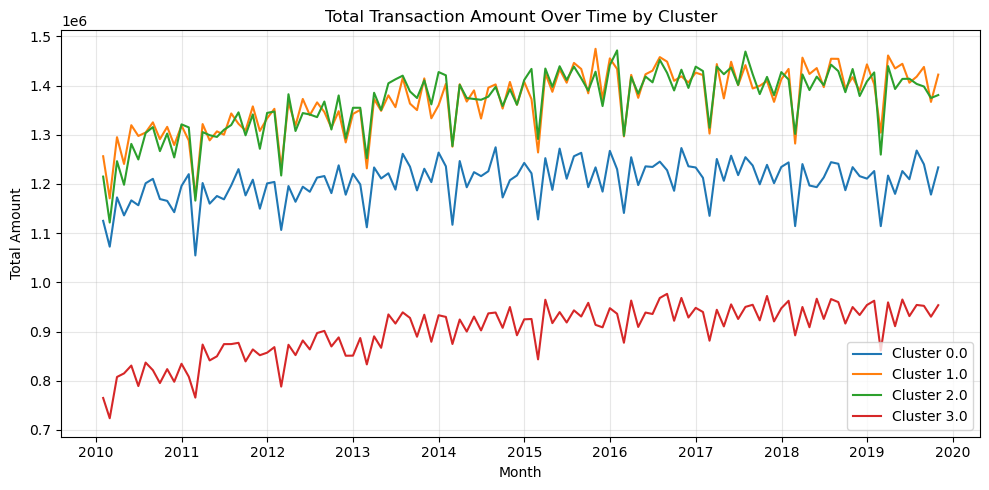

In [117]:
plt.figure(figsize=(10,5))
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c]
    plt.plot(sub['date'], sub['total_amount'], label=f'Cluster {c}')
plt.title('Total Transaction Amount Over Time by Cluster')
plt.xlabel('Month'); plt.ylabel('Total Amount')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


### Exploratory Analysis

#### 1. Total Spending Variation per Cluster

In [119]:
stats_by_cluster = cluster_monthly.groupby('Cluster')['total_amount'].agg(['mean','std','min','max']).reset_index()
stats_by_cluster


,Cluster,mean,std,min,max
0,0.0000,"1,204,377.3543","42,808.0917","1,054,691.6200","1,274,555.8600"
1,1.0000,"1,368,840.0453","63,101.8742","1,170,785.9300","1,474,733.3200"
2,2.0000,"1,366,190.8688","66,932.6856","1,121,603.4100","1,471,454.4300"
3,3.0000,"900,977.4969","53,226.1172","723,728.4800","976,610.5700"


#### 2. Rolling Mean & Variance per Cluster

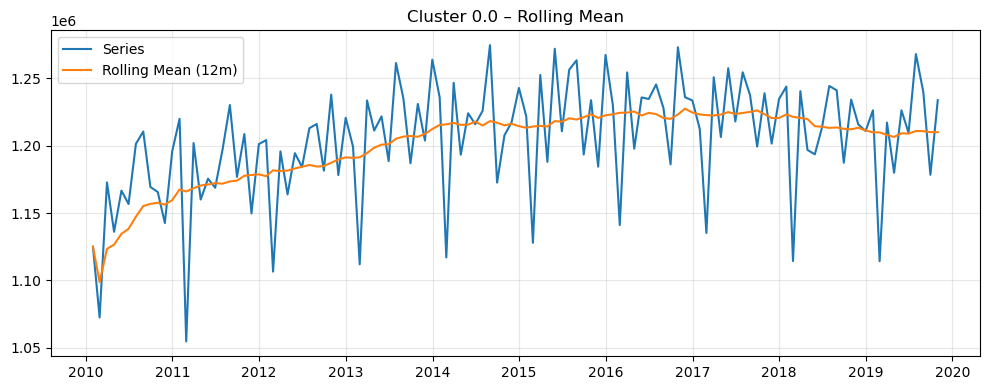

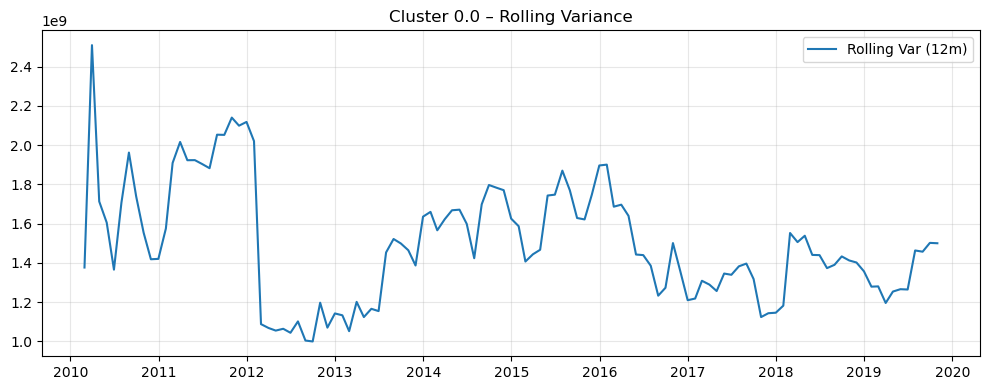

In [121]:
def rolling_stats(ts, window=12):
    rm = ts.rolling(window=window, min_periods=1).mean()
    rv = ts.rolling(window=window, min_periods=1).var()
    return rm, rv

cid = sorted(cluster_monthly['Cluster'].unique())[0]
ts0 = (cluster_monthly.query("Cluster == @cid")
                    .set_index('date')['total_amount']
                    .asfreq('M').dropna())

rm, rv = rolling_stats(ts0, window=12)
plt.figure(figsize=(10,4))
plt.plot(ts0.index, ts0.values, label='Series')
plt.plot(rm.index, rm.values, label='Rolling Mean (12m)')
plt.title(f'Cluster {cid} – Rolling Mean'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.plot(rv.index, rv.values, label='Rolling Var (12m)')
plt.title(f'Cluster {cid} – Rolling Variance'); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


#### 3. Seasonal-Trend Decomposition (STL)

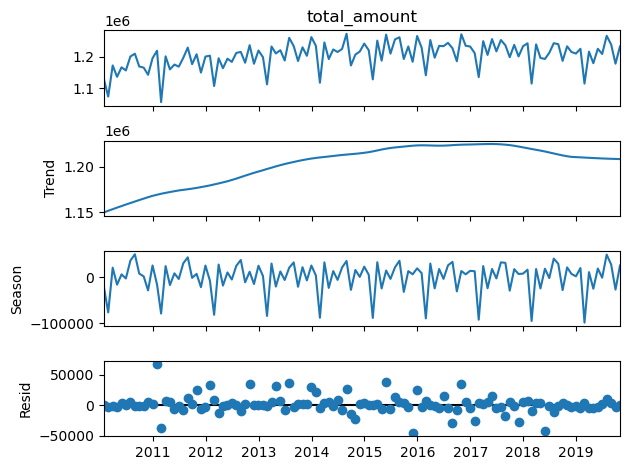

In [123]:
stl = STL(ts0, robust=True, period=12).fit()
fig = stl.plot()
plt.tight_layout(); plt.show()


#### Formal Stationarity Check

In [125]:
def adf_kpss_summary(ts):
    ts = ts.dropna()
    adf_stat, adf_p, *_ = adfuller(ts)
    kpss_stat, kpss_p, *_ = kpss(ts, regression='c', nlags='auto')
    return {
        'ADF_Statistic': adf_stat, 'ADF_pvalue': adf_p,
        'KPSS_Statistic': kpss_stat, 'KPSS_pvalue': kpss_p
    }

adf_kpss_summary(ts0)


{'ADF_Statistic': -3.221424390159261,
 'ADF_pvalue': 0.018777565745001362,
 'KPSS_Statistic': 1.3350629684152473,
 'KPSS_pvalue': 0.01}

#### Prophet helpers (prep & evaluation)

In [127]:
def to_prophet_frame(ts):
    # ts: Series with DatetimeIndex
    dfp = ts.reset_index()
    dfp.columns = ['ds', 'y']
    return dfp

def fit_prophet(dfp, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
                seasonality_mode='additive', changepoint_prior_scale=0.05, seasonality_prior_scale=10.0,
                add_monthly=False):
    m = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    if add_monthly:
        # approximate monthly cycle (in days)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(dfp)
    return m

def prophet_forecast(m, periods=12, freq='M'):
    future = m.make_future_dataframe(periods=periods, freq=freq, include_history=True)
    fc = m.predict(future)
    return fc

def rolling_forecast_prophet(ts, train_len=36, horizon=1, step=1, **prophet_kwargs):
    ts = ts.dropna()
    n = len(ts)

    preds, actuals, dates = [], [], []

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test = ts.iloc[start + train_len : start + train_len + horizon]

        dfp = to_prophet_frame(train)
        m = fit_prophet(dfp, **prophet_kwargs)

        future = m.make_future_dataframe(periods=horizon, freq='M', include_history=False)
        fc = m.predict(future)

        preds.extend(fc['yhat'].values.tolist())
        actuals.extend(test.values.tolist())
        dates.extend(test.index.tolist())

    res = pd.DataFrame({'date': dates, 'actual': actuals, 'pred': preds}).set_index('date')
    return res

def metrics_from_df(res):
    mae = mean_absolute_error(res['actual'], res['pred'])
    rmse = mean_squared_error(res['actual'], res['pred'], squared=False)
    mape = mean_absolute_percentage_error(res['actual'], res['pred'])
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


#### Example (one cluster) – rolling evaluation with Prophet

In [129]:
cluster_results = {}

for c in sorted(cluster_monthly['Cluster'].unique()):
    # 1. Build the series for ONE cluster
    ts_c = (
        cluster_monthly[cluster_monthly['Cluster'] == c]
        .sort_values('date')
        .set_index('date')['total_amount']
    )

    # 2. Rolling Prophet evaluation for that cluster
    res_c = rolling_forecast_prophet(
        ts_c,
        train_len=36,      
        horizon=1,         # 1-month-ahead forecasts
        step=1,            # move window forward one month at a time
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative',  # you can also try 'additive'
        add_monthly=False                   # or True if you want that extra seasonality
    )

    # 3. Compute metrics for this cluster
    metrics_c = metrics_from_df(res_c)

    cluster_results[c] = {
        'res': res_c,
        'metrics': metrics_c
    }

    print(f"Cluster {c} metrics:", metrics_c)


10:40:47 - cmdstanpy - INFO - Chain [1] start processing
10:40:47 - cmdstanpy - INFO - Chain [1] done processing
10:40:47 - cmdstanpy - INFO - Chain [1] start processing
10:40:47 - cmdstanpy - INFO - Chain [1] done processing
10:40:47 - cmdstanpy - INFO - Chain [1] start processing
10:40:47 - cmdstanpy - INFO - Chain [1] done processing
10:40:47 - cmdstanpy - INFO - Chain [1] start processing
10:40:47 - cmdstanpy - INFO - Chain [1] done processing
10:40:47 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1] done processing
10:40:48 - cmdstanpy - INFO - Chain [1] start processing
10:40:48 - cmdstanpy - INFO - Chain [1]

Cluster 0.0 metrics: {'MAE': 19520.32375217448, 'RMSE': 24220.32478282405, 'MAPE': 0.016057582165676}


10:40:58 - cmdstanpy - INFO - Chain [1] done processing
10:40:58 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:40:59 - cmdstanpy - INFO - Chain [1] done processing
10:40:59 - cmdstanpy - INFO - Chain [1] start processing
10:41:00 - cmdstanpy - INFO - Chain [1] done processing
10:41:00 - cmdstanpy - INFO - Chain [1] start processing
10:41:00 - cmdstanpy - INFO - Chain [1] done processing
10:41:00 - cmdstanpy - INFO - Chain [1] 

Cluster 1.0 metrics: {'MAE': 25165.461610424754, 'RMSE': 31603.87173266473, 'MAPE': 0.018083656745036546}


10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:11 - cmdstanpy - INFO - Chain [1] done processing
10:41:11 - cmdstanpy - INFO - Chain [1] start processing
10:41:12 - cmdstanpy - INFO - Chain [1] done processing
10:41:12 - cmdstanpy - INFO - Chain [1] start processing
10:41:12 - cmdstanpy - INFO - Chain [1] done processing
10:41:12 - cmdstanpy - INFO - Chain [1] start processing
10:41:12 - cmdstanpy - INFO - Chain [1] done processing
10:41:12 - cmdstanpy - INFO - Chain [1] start processing
10:41:12 - cmdstanpy - INFO - Chain [1] done processing
10:41:12 - cmdstanpy - INFO - Chain [1] 

Cluster 2.0 metrics: {'MAE': 21441.10834352683, 'RMSE': 25867.25964728532, 'MAPE': 0.015397345229809576}


10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing
10:41:23 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] start processing
10:41:24 - cmdstanpy - INFO - Chain [1] done processing
10:41:24 - cmdstanpy - INFO - Chain [1] 

Cluster 3.0 metrics: {'MAE': 18486.217129927554, 'RMSE': 22915.81438510555, 'MAPE': 0.020013400318694773}


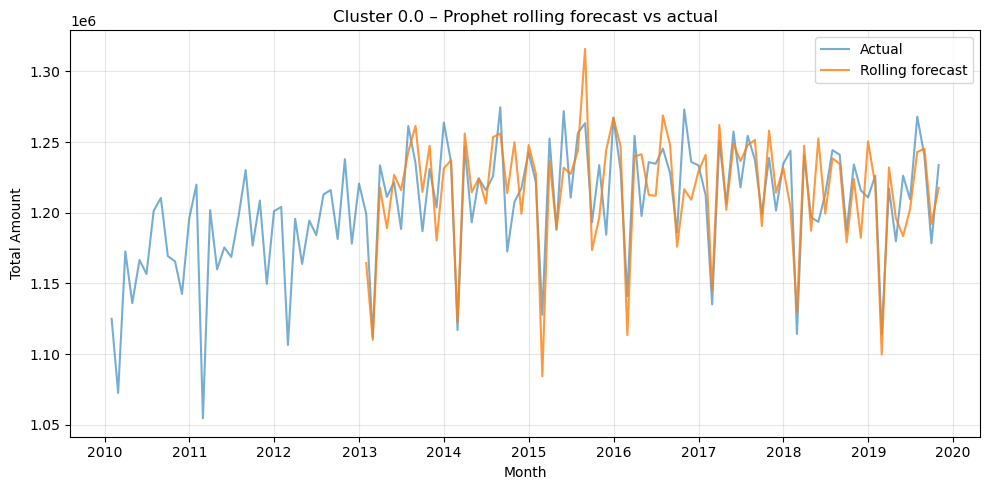

In [131]:
def plot_residual_fit(ts, res, title=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.plot(ts.index, ts.values, label='Actual', alpha=0.6)
    plt.plot(res.index, res['pred'], label='Rolling forecast', alpha=0.8)
    plt.title(title)
    plt.xlabel("Month"); plt.ylabel("Total Amount")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

# Example for cluster 0.0
ts0 = (
    cluster_monthly[cluster_monthly['Cluster']==0.0]
    .sort_values('date')
    .set_index('date')['total_amount']
)

res0 = cluster_results[0.0]['res']  # from your loop
plot_residual_fit(ts0, res0, title="Cluster 0.0 – Prophet rolling forecast vs actual")


#### Prophet simple hyperparameter search 

In [133]:
param_grid = []
for mode in ['additive', 'multiplicative']:
    for cps in [0.01, 0.05, 0.10]:
        for add_monthly in [False, True]:
            param_grid.append({
                'seasonality_mode': mode,
                'changepoint_prior_scale': cps,
                'add_monthly': add_monthly
            })
param_grid

[{'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.01,
  'add_monthly': False},
 {'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.01,
  'add_monthly': True},
 {'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.05,
  'add_monthly': False},
 {'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.05,
  'add_monthly': True},
 {'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.1,
  'add_monthly': False},
 {'seasonality_mode': 'additive',
  'changepoint_prior_scale': 0.1,
  'add_monthly': True},
 {'seasonality_mode': 'multiplicative',
  'changepoint_prior_scale': 0.01,
  'add_monthly': False},
 {'seasonality_mode': 'multiplicative',
  'changepoint_prior_scale': 0.01,
  'add_monthly': True},
 {'seasonality_mode': 'multiplicative',
  'changepoint_prior_scale': 0.05,
  'add_monthly': False},
 {'seasonality_mode': 'multiplicative',
  'changepoint_prior_scale': 0.05,
  'add_monthly': True},
 {'seasonality_mode': 'multiplicative',
  '

In [135]:
best_configs = {}

for c in sorted(cluster_monthly['Cluster'].unique()):
    print(f"\n=== Cluster {c} ===")
    
    ts_c = (
        cluster_monthly[cluster_monthly['Cluster'] == c]
        .sort_values('date')
        .set_index('date')['total_amount']
    )
    
    best_configs[c] = None
    
    for params in param_grid:
        
        res_c = rolling_forecast_prophet(
            ts_c,
            train_len=36,
            horizon=1,
            step=1,
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale'],
            add_monthly=params['add_monthly']
        )
        
        metrics_c = metrics_from_df(res_c)
        
        print(
            f"  params={params} "
            f"-> MAPE={metrics_c['MAPE']:.4f}, "
            f"MAE={metrics_c['MAE']:.1f}, "
            f"RMSE={metrics_c['RMSE']:.1f}"
        )
        
        if (
            best_configs[c] is None 
            or metrics_c['MAPE'] < best_configs[c]['metrics']['MAPE']
        ):
            best_configs[c] = {
                'params': params,
                'metrics': metrics_c,
                'res': res_c
            }

print("\n\nBest configs per cluster:")
for c, info in best_configs.items():
    print(f"Cluster {c}: MAPE={info['metrics']['MAPE']:.4f}, params={info['params']}")


10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing



=== Cluster 0.0 ===


10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:23 - cmdstanpy - INFO - Chain [1] start processing
10:46:23 - cmdstanpy - INFO - Chain [1] done processing
10:46:24 - cmdstanpy - INFO - Chain [1] start processing
10:46:24 - cmdstanpy - INFO - Chain [1] done processing
10:46:24 - cmdstanpy - INFO - Chain [1] start processing
10:46:24 - cmdstanpy - INFO - Chain [1] done processing
10:46:24 - cmdstanpy - INFO - Chain [1] start processing
10:46:24 - cmdstanpy - INFO - Chain [1] done processing
10:46:24 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0149, MAE=18110.3, RMSE=22716.0


10:46:32 - cmdstanpy - INFO - Chain [1] done processing
10:46:32 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:33 - cmdstanpy - INFO - Chain [1] done processing
10:46:33 - cmdstanpy - INFO - Chain [1] start processing
10:46:34 - cmdstanpy - INFO - Chain [1] done processing
10:46:34 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0347, MAE=40559.6, RMSE=85740.2


10:46:43 - cmdstanpy - INFO - Chain [1] done processing
10:46:43 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:44 - cmdstanpy - INFO - Chain [1] done processing
10:46:44 - cmdstanpy - INFO - Chain [1] start processing
10:46:45 - cmdstanpy - INFO - Chain [1] done processing
10:46:45 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0161, MAE=19549.5, RMSE=24326.5


10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:55 - cmdstanpy - INFO - Chain [1] done processing
10:46:55 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] start processing
10:46:56 - cmdstanpy - INFO - Chain [1] done processing
10:46:56 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0347, MAE=40750.0, RMSE=78780.0


10:47:08 - cmdstanpy - INFO - Chain [1] done processing
10:47:08 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:09 - cmdstanpy - INFO - Chain [1] done processing
10:47:09 - cmdstanpy - INFO - Chain [1] start processing
10:47:10 - cmdstanpy - INFO - Chain [1] done processing
10:47:10 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0171, MAE=20741.3, RMSE=25538.6


10:47:33 - cmdstanpy - INFO - Chain [1] done processing
10:47:33 - cmdstanpy - INFO - Chain [1] start processing
10:47:44 - cmdstanpy - INFO - Chain [1] done processing
10:47:44 - cmdstanpy - INFO - Chain [1] start processing
10:47:56 - cmdstanpy - INFO - Chain [1] done processing
10:47:56 - cmdstanpy - INFO - Chain [1] start processing
10:48:07 - cmdstanpy - INFO - Chain [1] done processing
10:48:07 - cmdstanpy - INFO - Chain [1] start processing
10:48:19 - cmdstanpy - INFO - Chain [1] done processing
10:48:19 - cmdstanpy - INFO - Chain [1] start processing
10:48:30 - cmdstanpy - INFO - Chain [1] done processing
10:48:30 - cmdstanpy - INFO - Chain [1] start processing
10:48:42 - cmdstanpy - INFO - Chain [1] done processing
10:48:42 - cmdstanpy - INFO - Chain [1] start processing
10:48:42 - cmdstanpy - INFO - Chain [1] done processing
10:48:42 - cmdstanpy - INFO - Chain [1] start processing
10:48:43 - cmdstanpy - INFO - Chain [1] done processing
10:48:43 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0414, MAE=48890.0, RMSE=86552.6


10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0150, MAE=18204.0, RMSE=22825.4


10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0303, MAE=35705.6, RMSE=63068.0


10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0161, MAE=19520.3, RMSE=24220.3


10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:37 - cmdstanpy - INFO - Chain [1] done processing
10:51:38 - cmdstanpy - INFO - Chain [1] start processing
10:51:49 - cmdstanpy - INFO - Chain [1] done processing
10:51:49 - cmdstanpy - INFO - Chain [1] start processing
10:52:01 - cmdstanpy - INFO - Chain [1] done processing
10:52:01 - cmdstanpy - INFO - Chain [1] start processing
10:52:01 - cmdstanpy - INFO - Chain [1] done processing
10:52:01 - cmdstanpy - INFO - Chain [1] start processing
10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing
10:52:13 - cmdstanpy - INFO - Chain [1] done processing
10:52:13 - cmdstanpy - INFO - Chain [1] start processing
10:52:15 - cmdstanpy - INFO - Chain [1] done processing
10:52:15 - cmdstanpy - INFO - Chain [1] start processing
10:52:27 - cmdstanpy - INFO - Chain [1] done processing
10:52:27 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0447, MAE=53303.2, RMSE=84388.4


10:57:34 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:35 - cmdstanpy - INFO - Chain [1] done processing
10:57:35 - cmdstanpy - INFO - Chain [1] start processing
10:57:36 - cmdstanpy - INFO - Chain [1] done processing
10:57:36 - cmdstanpy - INFO - Chain [1] start processing
10:57:36 - cmdstanpy - INFO - Chain [1] done processing
10:57:36 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0170, MAE=20703.7, RMSE=25466.3


10:57:49 - cmdstanpy - INFO - Chain [1] done processing
10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:58:01 - cmdstanpy - INFO - Chain [1] done processing
10:58:01 - cmdstanpy - INFO - Chain [1] start processing
10:58:13 - cmdstanpy - INFO - Chain [1] done processing
10:58:13 - cmdstanpy - INFO - Chain [1] start processing
10:58:25 - cmdstanpy - INFO - Chain [1] done processing
10:58:25 - cmdstanpy - INFO - Chain [1] start processing
10:58:37 - cmdstanpy - INFO - Chain [1] done processing
10:58:37 - cmdstanpy - INFO - Chain [1] start processing
10:58:49 - cmdstanpy - INFO - Chain [1] done processing
10:58:49 - cmdstanpy - INFO - Chain [1] start processing
10:59:01 - cmdstanpy - INFO - Chain [1] done processing
10:59:01 - cmdstanpy - INFO - Chain [1] start processing
10:59:13 - cmdstanpy - INFO - Chain [1] done processing
10:59:13 - cmdstanpy - INFO - Chain [1] start processing
10:59:25 - cmdstanpy - INFO - Chain [1] done processing
10:59:25 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0491, MAE=59076.8, RMSE=88782.7

=== Cluster 1.0 ===


11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] start processing
11:10:20 - cmdstanpy - INFO - Chain [1] done processing
11:10:20 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0147, MAE=20483.4, RMSE=25784.8


11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:30 - cmdstanpy - INFO - Chain [1] start processing
11:10:30 - cmdstanpy - INFO - Chain [1] done processing
11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
11:10:31 - cmdstanpy - INFO - Chain [1] start processing
11:10:31 - cmdstanpy - INFO - Chain [1] done processing
11:10:31 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0532, MAE=71099.4, RMSE=201147.8


11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:42 - cmdstanpy - INFO - Chain [1] done processing
11:10:42 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:43 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:43 - cmdstanpy - INFO - Chain [1] start processing
11:10:43 - cmdstanpy - INFO - Chain [1] done processing
11:10:43 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0178, MAE=24746.3, RMSE=31305.4


11:10:54 - cmdstanpy - INFO - Chain [1] done processing
11:10:54 - cmdstanpy - INFO - Chain [1] start processing
11:10:54 - cmdstanpy - INFO - Chain [1] done processing
11:10:54 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:55 - cmdstanpy - INFO - Chain [1] done processing
11:10:55 - cmdstanpy - INFO - Chain [1] start processing
11:10:56 - cmdstanpy - INFO - Chain [1] done processing
11:10:56 - cmdstanpy - INFO - Chain [1] start processing
11:10:56 - cmdstanpy - INFO - Chain [1] done processing
11:10:56 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0506, MAE=67963.8, RMSE=152506.7


11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:22 - cmdstanpy - INFO - Chain [1] done processing
11:11:22 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:23 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:23 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:23 - cmdstanpy - INFO - Chain [1] start processing
11:11:23 - cmdstanpy - INFO - Chain [1] done processing
11:11:23 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0190, MAE=26416.5, RMSE=33725.2


11:11:36 - cmdstanpy - INFO - Chain [1] done processing
11:11:36 - cmdstanpy - INFO - Chain [1] start processing
11:11:36 - cmdstanpy - INFO - Chain [1] done processing
11:11:36 - cmdstanpy - INFO - Chain [1] start processing
11:11:36 - cmdstanpy - INFO - Chain [1] done processing
11:11:36 - cmdstanpy - INFO - Chain [1] start processing
11:11:37 - cmdstanpy - INFO - Chain [1] done processing
11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:37 - cmdstanpy - INFO - Chain [1] done processing
11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:48 - cmdstanpy - INFO - Chain [1] done processing
11:11:48 - cmdstanpy - INFO - Chain [1] start processing
11:12:00 - cmdstanpy - INFO - Chain [1] done processing
11:12:00 - cmdstanpy - INFO - Chain [1] start processing
11:12:12 - cmdstanpy - INFO - Chain [1] done processing
11:12:12 - cmdstanpy - INFO - Chain [1] start processing
11:12:12 - cmdstanpy - INFO - Chain [1] done processing
11:12:12 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0546, MAE=73807.2, RMSE=142158.3


11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:00 - cmdstanpy - INFO - Chain [1] done processing
11:16:00 - cmdstanpy - INFO - Chain [1] start processing
11:16:01 - cmdstanpy - INFO - Chain [1] done processing
11:16:01 - cmdstanpy - INFO - Chain [1] start processing
11:16:01 - cmdstanpy - INFO - Chain [1] done processing
11:16:01 - cmdstanpy - INFO - Chain [1] start processing
11:16:01 - cmdstanpy - INFO - Chain [1] done processing
11:16:01 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0148, MAE=20648.4, RMSE=25927.7


11:16:11 - cmdstanpy - INFO - Chain [1] done processing
11:16:11 - cmdstanpy - INFO - Chain [1] start processing
11:16:13 - cmdstanpy - INFO - Chain [1] done processing
11:16:13 - cmdstanpy - INFO - Chain [1] start processing
11:16:15 - cmdstanpy - INFO - Chain [1] done processing
11:16:15 - cmdstanpy - INFO - Chain [1] start processing
11:16:15 - cmdstanpy - INFO - Chain [1] done processing
11:16:15 - cmdstanpy - INFO - Chain [1] start processing
11:16:18 - cmdstanpy - INFO - Chain [1] done processing
11:16:18 - cmdstanpy - INFO - Chain [1] start processing
11:16:18 - cmdstanpy - INFO - Chain [1] done processing
11:16:18 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] done processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:31 - cmdstanpy - INFO - Chain [1] done processing
11:16:31 - cmdstanpy - INFO - Chain [1] start processing
11:16:44 - cmdstanpy - INFO - Chain [1] done processing
11:16:44 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0371, MAE=50375.7, RMSE=97884.1


11:17:34 - cmdstanpy - INFO - Chain [1] done processing
11:17:34 - cmdstanpy - INFO - Chain [1] start processing
11:17:34 - cmdstanpy - INFO - Chain [1] done processing
11:17:34 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:35 - cmdstanpy - INFO - Chain [1] done processing
11:17:35 - cmdstanpy - INFO - Chain [1] start processing
11:17:36 - cmdstanpy - INFO - Chain [1] done processing
11:17:36 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0181, MAE=25165.5, RMSE=31603.9


11:17:49 - cmdstanpy - INFO - Chain [1] done processing
11:17:49 - cmdstanpy - INFO - Chain [1] start processing
11:18:01 - cmdstanpy - INFO - Chain [1] done processing
11:18:02 - cmdstanpy - INFO - Chain [1] start processing
11:18:14 - cmdstanpy - INFO - Chain [1] done processing
11:18:14 - cmdstanpy - INFO - Chain [1] start processing
11:18:27 - cmdstanpy - INFO - Chain [1] done processing
11:18:27 - cmdstanpy - INFO - Chain [1] start processing
11:18:39 - cmdstanpy - INFO - Chain [1] done processing
11:18:39 - cmdstanpy - INFO - Chain [1] start processing
11:18:52 - cmdstanpy - INFO - Chain [1] done processing
11:18:52 - cmdstanpy - INFO - Chain [1] start processing
11:19:04 - cmdstanpy - INFO - Chain [1] done processing
11:19:04 - cmdstanpy - INFO - Chain [1] start processing
11:19:16 - cmdstanpy - INFO - Chain [1] done processing
11:19:16 - cmdstanpy - INFO - Chain [1] start processing
11:19:28 - cmdstanpy - INFO - Chain [1] done processing
11:19:28 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0548, MAE=74799.5, RMSE=132369.2


11:30:24 - cmdstanpy - INFO - Chain [1] done processing
11:30:24 - cmdstanpy - INFO - Chain [1] start processing
11:30:24 - cmdstanpy - INFO - Chain [1] done processing
11:30:24 - cmdstanpy - INFO - Chain [1] start processing
11:30:25 - cmdstanpy - INFO - Chain [1] done processing
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:25 - cmdstanpy - INFO - Chain [1] done processing
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:25 - cmdstanpy - INFO - Chain [1] done processing
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:25 - cmdstanpy - INFO - Chain [1] done processing
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:25 - cmdstanpy - INFO - Chain [1] done processing
11:30:25 - cmdstanpy - INFO - Chain [1] start processing
11:30:26 - cmdstanpy - INFO - Chain [1] done processing
11:30:26 - cmdstanpy - INFO - Chain [1] start processing
11:30:26 - cmdstanpy - INFO - Chain [1] done processing
11:30:26 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0190, MAE=26400.1, RMSE=33313.6


11:30:50 - cmdstanpy - INFO - Chain [1] done processing
11:30:50 - cmdstanpy - INFO - Chain [1] start processing
11:31:02 - cmdstanpy - INFO - Chain [1] done processing
11:31:02 - cmdstanpy - INFO - Chain [1] start processing
11:31:14 - cmdstanpy - INFO - Chain [1] done processing
11:31:14 - cmdstanpy - INFO - Chain [1] start processing
11:31:26 - cmdstanpy - INFO - Chain [1] done processing
11:31:26 - cmdstanpy - INFO - Chain [1] start processing
11:31:38 - cmdstanpy - INFO - Chain [1] done processing
11:31:38 - cmdstanpy - INFO - Chain [1] start processing
11:31:50 - cmdstanpy - INFO - Chain [1] done processing
11:31:50 - cmdstanpy - INFO - Chain [1] start processing
11:32:01 - cmdstanpy - INFO - Chain [1] done processing
11:32:01 - cmdstanpy - INFO - Chain [1] start processing
11:32:13 - cmdstanpy - INFO - Chain [1] done processing
11:32:13 - cmdstanpy - INFO - Chain [1] start processing
11:32:25 - cmdstanpy - INFO - Chain [1] done processing
11:32:25 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0550, MAE=74894.4, RMSE=128337.5

=== Cluster 2.0 ===


11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:19 - cmdstanpy - INFO - Chain [1] done processing
11:45:19 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] start processing
11:45:20 - cmdstanpy - INFO - Chain [1] done processing
11:45:20 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0140, MAE=19401.0, RMSE=24681.6


11:45:29 - cmdstanpy - INFO - Chain [1] done processing
11:45:29 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:30 - cmdstanpy - INFO - Chain [1] done processing
11:45:30 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing
11:45:31 - cmdstanpy - INFO - Chain [1] start processing
11:45:31 - cmdstanpy - INFO - Chain [1] done processing
11:45:31 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0523, MAE=69803.3, RMSE=269991.7


11:45:42 - cmdstanpy - INFO - Chain [1] done processing
11:45:42 - cmdstanpy - INFO - Chain [1] start processing
11:45:42 - cmdstanpy - INFO - Chain [1] done processing
11:45:42 - cmdstanpy - INFO - Chain [1] start processing
11:45:42 - cmdstanpy - INFO - Chain [1] done processing
11:45:42 - cmdstanpy - INFO - Chain [1] start processing
11:45:42 - cmdstanpy - INFO - Chain [1] done processing
11:45:42 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] start processing
11:45:43 - cmdstanpy - INFO - Chain [1] done processing
11:45:43 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0157, MAE=21800.0, RMSE=26261.5


11:45:55 - cmdstanpy - INFO - Chain [1] done processing
11:45:55 - cmdstanpy - INFO - Chain [1] start processing
11:45:56 - cmdstanpy - INFO - Chain [1] done processing
11:45:56 - cmdstanpy - INFO - Chain [1] start processing
11:46:07 - cmdstanpy - INFO - Chain [1] done processing
11:46:07 - cmdstanpy - INFO - Chain [1] start processing
11:46:07 - cmdstanpy - INFO - Chain [1] done processing
11:46:07 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing
11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing
11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing
11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:10 - cmdstanpy - INFO - Chain [1] done processing
11:46:10 - cmdstanpy - INFO - Chain [1] start processing
11:46:11 - cmdstanpy - INFO - Chain [1] done processing
11:46:11 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0428, MAE=57682.2, RMSE=157396.4


11:47:03 - cmdstanpy - INFO - Chain [1] done processing
11:47:03 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:04 - cmdstanpy - INFO - Chain [1] done processing
11:47:04 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing
11:47:05 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing
11:47:05 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0175, MAE=24404.7, RMSE=30669.7


11:47:37 - cmdstanpy - INFO - Chain [1] done processing
11:47:37 - cmdstanpy - INFO - Chain [1] start processing
11:47:49 - cmdstanpy - INFO - Chain [1] done processing
11:47:49 - cmdstanpy - INFO - Chain [1] start processing
11:48:00 - cmdstanpy - INFO - Chain [1] done processing
11:48:00 - cmdstanpy - INFO - Chain [1] start processing
11:48:12 - cmdstanpy - INFO - Chain [1] done processing
11:48:12 - cmdstanpy - INFO - Chain [1] start processing
11:48:23 - cmdstanpy - INFO - Chain [1] done processing
11:48:23 - cmdstanpy - INFO - Chain [1] start processing
11:48:35 - cmdstanpy - INFO - Chain [1] done processing
11:48:35 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:58 - cmdstanpy - INFO - Chain [1] done processing
11:48:58 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0601, MAE=81029.2, RMSE=235873.3


11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:39 - cmdstanpy - INFO - Chain [1] done processing
11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] start processing
11:56:40 - cmdstanpy - INFO - Chain [1] done processing
11:56:40 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0140, MAE=19421.8, RMSE=24926.9


11:56:51 - cmdstanpy - INFO - Chain [1] done processing
11:56:51 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:06 - cmdstanpy - INFO - Chain [1] done processing
11:57:06 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1] done processing
11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:08 - cmdstanpy - INFO - Chain [1] done processing
11:57:08 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] start processing
11:57:09 - cmdstanpy - INFO - Chain [1] done processing
11:57:09 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0306, MAE=41593.9, RMSE=81077.5


11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:44 - cmdstanpy - INFO - Chain [1] done processing
11:57:44 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:45 - cmdstanpy - INFO - Chain [1] done processing
11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:46 - cmdstanpy - INFO - Chain [1] done processing
11:57:46 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0154, MAE=21441.1, RMSE=25867.3


11:58:09 - cmdstanpy - INFO - Chain [1] done processing
11:58:09 - cmdstanpy - INFO - Chain [1] start processing
11:58:21 - cmdstanpy - INFO - Chain [1] done processing
11:58:21 - cmdstanpy - INFO - Chain [1] start processing
11:58:33 - cmdstanpy - INFO - Chain [1] done processing
11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:45 - cmdstanpy - INFO - Chain [1] done processing
11:58:45 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:59:05 - cmdstanpy - INFO - Chain [1] done processing
11:59:05 - cmdstanpy - INFO - Chain [1] start processing
11:59:17 - cmdstanpy - INFO - Chain [1] done processing
11:59:17 - cmdstanpy - INFO - Chain [1] start processing
11:59:29 - cmdstanpy - INFO - Chain [1] done processing
11:59:29 - cmdstanpy - INFO - Chain [1] start processing
11:59:41 - cmdstanpy - INFO - Chain [1] done processing
11:59:41 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0351, MAE=48570.6, RMSE=64543.0


12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:18 - cmdstanpy - INFO - Chain [1] done processing
12:13:18 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1] done processing
12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:19 - cmdstanpy - INFO - Chain [1]

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0179, MAE=24936.4, RMSE=31428.0


12:13:54 - cmdstanpy - INFO - Chain [1] done processing
12:13:54 - cmdstanpy - INFO - Chain [1] start processing
12:14:06 - cmdstanpy - INFO - Chain [1] done processing
12:14:06 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:30 - cmdstanpy - INFO - Chain [1] done processing
12:14:30 - cmdstanpy - INFO - Chain [1] start processing
12:14:42 - cmdstanpy - INFO - Chain [1] done processing
12:14:42 - cmdstanpy - INFO - Chain [1] start processing
12:14:54 - cmdstanpy - INFO - Chain [1] done processing
12:14:54 - cmdstanpy - INFO - Chain [1] start processing
12:15:06 - cmdstanpy - INFO - Chain [1] done processing
12:15:06 - cmdstanpy - INFO - Chain [1] start processing
12:15:19 - cmdstanpy - INFO - Chain [1] done processing
12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:31 - cmdstanpy - INFO - Chain [1] done processing
12:15:31 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0384, MAE=52959.3, RMSE=74201.1

=== Cluster 3.0 ===


12:30:09 - cmdstanpy - INFO - Chain [1] done processing
12:30:09 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing
12:30:10 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0188, MAE=17395.8, RMSE=21604.4


12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] start processing
12:30:21 - cmdstanpy - INFO - Chain [1] done processing
12:30:21 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0540, MAE=48522.3, RMSE=182464.0


12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:32 - cmdstanpy - INFO - Chain [1] done processing
12:30:32 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1] done processing
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:33 - cmdstanpy - INFO - Chain [1]

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0198, MAE=18276.8, RMSE=22657.5


12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] start processing
12:30:45 - cmdstanpy - INFO - Chain [1] done processing
12:30:45 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0571, MAE=51432.5, RMSE=167357.5


12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:58 - cmdstanpy - INFO - Chain [1] start processing
12:30:58 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:30:59 - cmdstanpy - INFO - Chain [1] done processing
12:30:59 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0213, MAE=19704.0, RMSE=24703.5


12:31:12 - cmdstanpy - INFO - Chain [1] done processing
12:31:12 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:13 - cmdstanpy - INFO - Chain [1] done processing
12:31:13 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:25 - cmdstanpy - INFO - Chain [1] done processing
12:31:25 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0520, MAE=47455.6, RMSE=73107.9


12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] start processing
12:35:06 - cmdstanpy - INFO - Chain [1] done processing
12:35:06 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': False} -> MAPE=0.0189, MAE=17445.7, RMSE=21869.8


12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'add_monthly': True} -> MAPE=0.0355, MAE=32250.1, RMSE=55851.9


12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:27 - cmdstanpy - INFO - Chain [1] done processing
12:35:27 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': False} -> MAPE=0.0200, MAE=18486.2, RMSE=22915.8


12:35:39 - cmdstanpy - INFO - Chain [1] done processing
12:35:39 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:40 - cmdstanpy - INFO - Chain [1] done processing
12:35:40 - cmdstanpy - INFO - Chain [1] start processing
12:35:52 - cmdstanpy - INFO - Chain [1] done processing
12:35:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing
12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:04 - cmdstanpy - INFO - Chain [1] done processing
12:36:04 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:16 - cmdstanpy - INFO - Chain [1] done processing
12:36:16 - cmdstanpy - INFO - Chain [1] start processing
12:36:17 - cmdstanpy - INFO - Chain [1] done processing
12:36:17 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05, 'add_monthly': True} -> MAPE=0.0523, MAE=47700.7, RMSE=105812.7


13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:54 - cmdstanpy - INFO - Chain [1] done processing
13:09:54 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:55 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': False} -> MAPE=0.0218, MAE=20141.2, RMSE=25136.9


13:10:07 - cmdstanpy - INFO - Chain [1] done processing
13:10:07 - cmdstanpy - INFO - Chain [1] start processing
13:10:19 - cmdstanpy - INFO - Chain [1] done processing
13:10:19 - cmdstanpy - INFO - Chain [1] start processing
13:10:19 - cmdstanpy - INFO - Chain [1] done processing
13:10:19 - cmdstanpy - INFO - Chain [1] start processing
13:10:31 - cmdstanpy - INFO - Chain [1] done processing
13:10:31 - cmdstanpy - INFO - Chain [1] start processing
13:10:43 - cmdstanpy - INFO - Chain [1] done processing
13:10:43 - cmdstanpy - INFO - Chain [1] start processing
13:10:55 - cmdstanpy - INFO - Chain [1] done processing
13:10:55 - cmdstanpy - INFO - Chain [1] start processing
13:11:07 - cmdstanpy - INFO - Chain [1] done processing
13:11:07 - cmdstanpy - INFO - Chain [1] start processing
13:11:19 - cmdstanpy - INFO - Chain [1] done processing
13:11:19 - cmdstanpy - INFO - Chain [1] start processing
13:11:30 - cmdstanpy - INFO - Chain [1] done processing
13:11:30 - cmdstanpy - INFO - Chain [1] 

  params={'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.1, 'add_monthly': True} -> MAPE=0.0683, MAE=62315.3, RMSE=106908.7


Best configs per cluster:
Cluster 0.0: MAPE=0.0149, params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}
Cluster 1.0: MAPE=0.0147, params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}
Cluster 2.0: MAPE=0.0140, params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}
Cluster 3.0: MAPE=0.0188, params={'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}


In [152]:
import pickle

with open("best_configs.pkl", "wb") as f:
    pickle.dump(best_configs, f)

print("Saved best_configs.pkl successfully!")


Saved best_configs.pkl successfully!


In [154]:
import pickle

with open("best_configs.pkl", "rb") as f:
    best_configs = pickle.load(f)

print(best_configs)


{0.0: {'params': {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}, 'metrics': {'MAE': 18110.32700920064, 'RMSE': 22716.02214618158, 'MAPE': 0.01490947602515728}, 'res':                    actual           pred
date                                    
2013-01-31 1,199,131.0300 1,162,922.5028
2013-02-28 1,111,931.6600 1,108,537.2407
2013-03-31 1,233,529.0900 1,211,407.6505
2013-04-30 1,211,197.2000 1,178,959.1079
2013-05-31 1,221,700.5200 1,215,057.2243
...                   ...            ...
2019-06-30 1,209,527.9100 1,201,854.7248
2019-07-31 1,267,919.3200 1,242,159.4622
2019-08-31 1,239,894.4600 1,239,639.6538
2019-09-30 1,178,359.4100 1,184,130.0644
2019-10-31 1,233,735.6400 1,207,966.4746

[82 rows x 2 columns]}, 1.0: {'params': {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'add_monthly': False}, 'metrics': {'MAE': 20483.39314912858, 'RMSE': 25784.807375156546, 'MAPE': 0.014680189858387725}, 'res':                    actual

# FITTING BEST PARAMETERS

In [142]:
# 1. Fit final models and forecasts per cluster using best_configs

final_models = {}
final_forecasts = {}

for c in sorted(cluster_monthly['Cluster'].unique()):
    print(f"Fitting final model for cluster {c}")
    
    # full series for this cluster
    ts_c = (
        cluster_monthly[cluster_monthly['Cluster'] == c]
        .sort_values('date')
        .set_index('date')['total_amount']
    )
    dfp_c = to_prophet_frame(ts_c)
    
    best_params = best_configs[c]['params']
    
    m_c = fit_prophet(
        dfp_c,
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=best_params['seasonality_mode'],
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        add_monthly=best_params['add_monthly']
    )
    fc_c = prophet_forecast(m_c, periods=12, freq='M')  # 12-month forecast
    
    final_models[c] = m_c
    final_forecasts[c] = fc_c


13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing
13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing


Fitting final model for cluster 0.0
Fitting final model for cluster 1.0
Fitting final model for cluster 2.0


13:37:27 - cmdstanpy - INFO - Chain [1] start processing
13:37:27 - cmdstanpy - INFO - Chain [1] done processing


Fitting final model for cluster 3.0


# VISUALIZATION

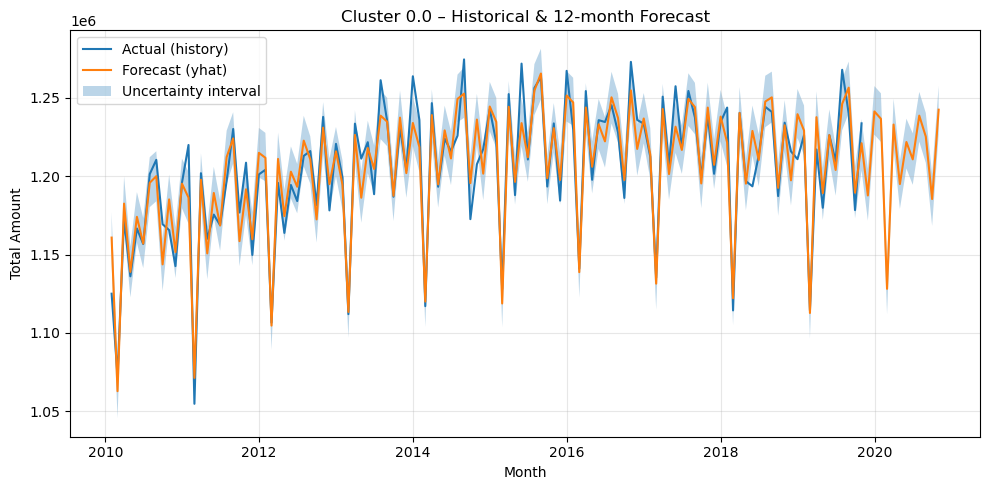

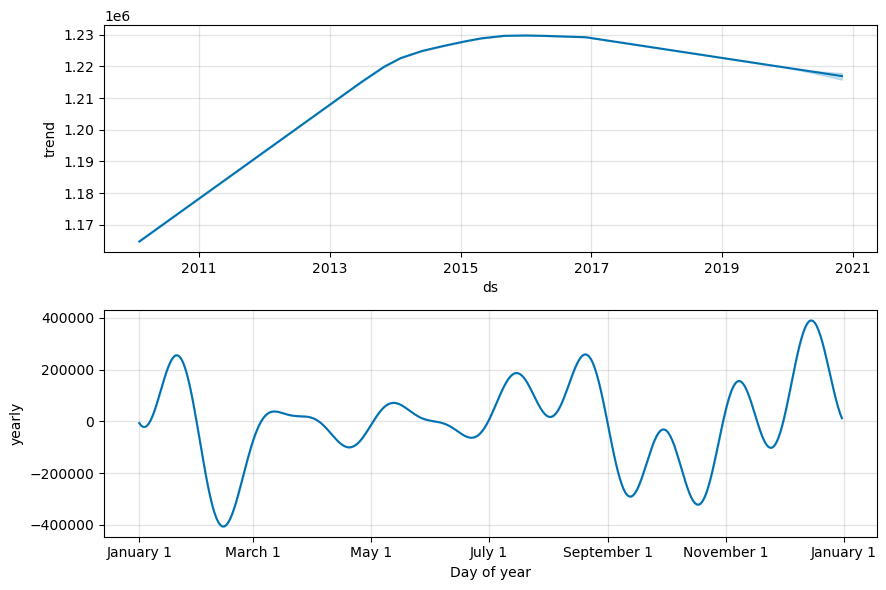

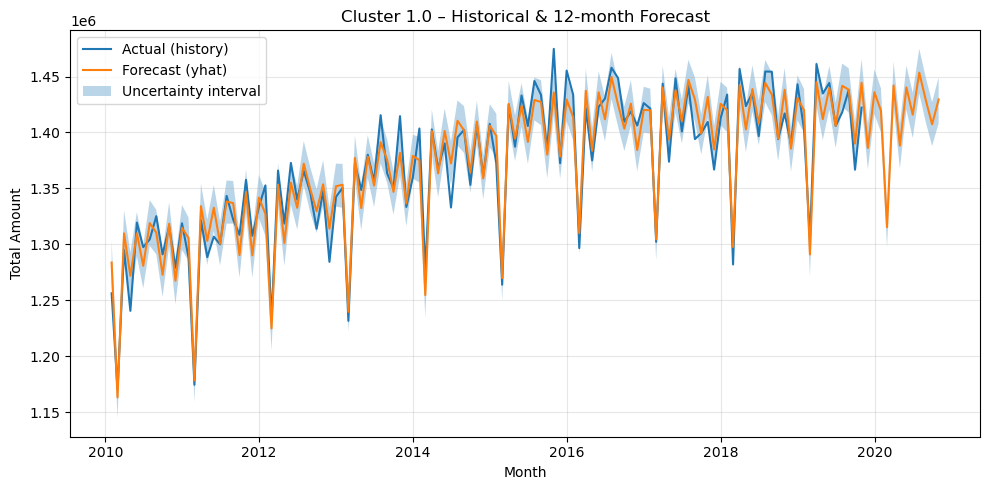

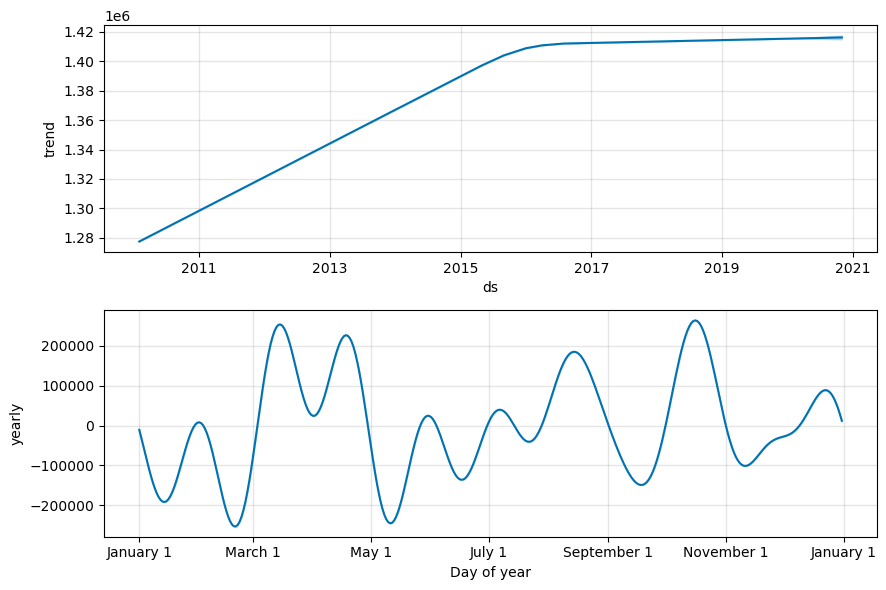

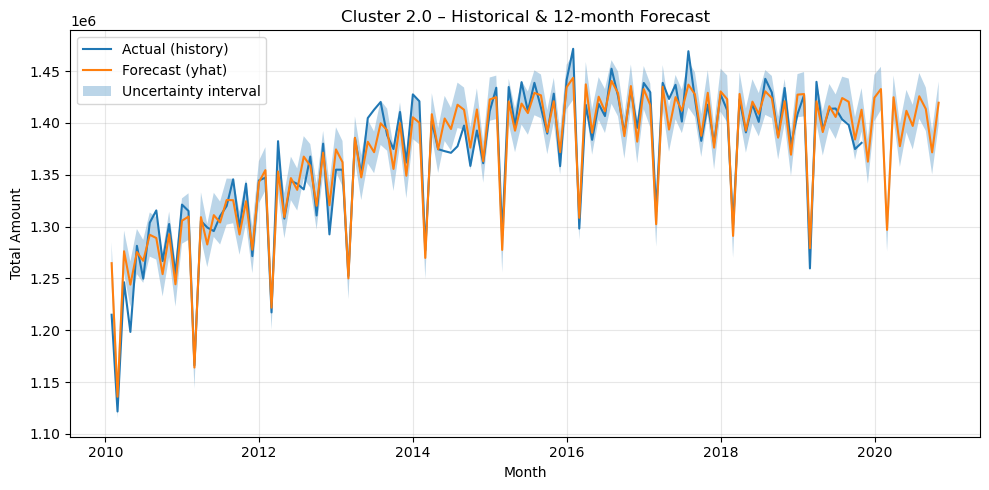

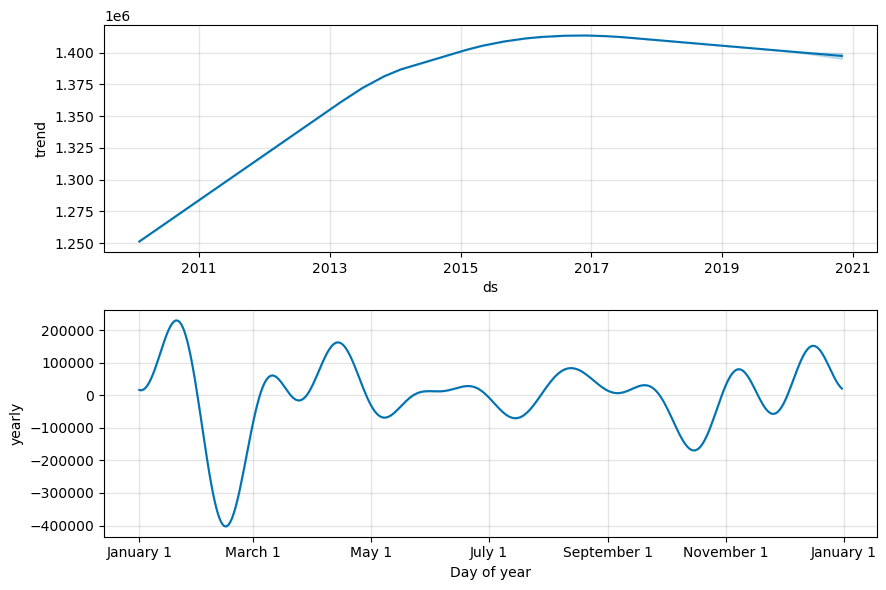

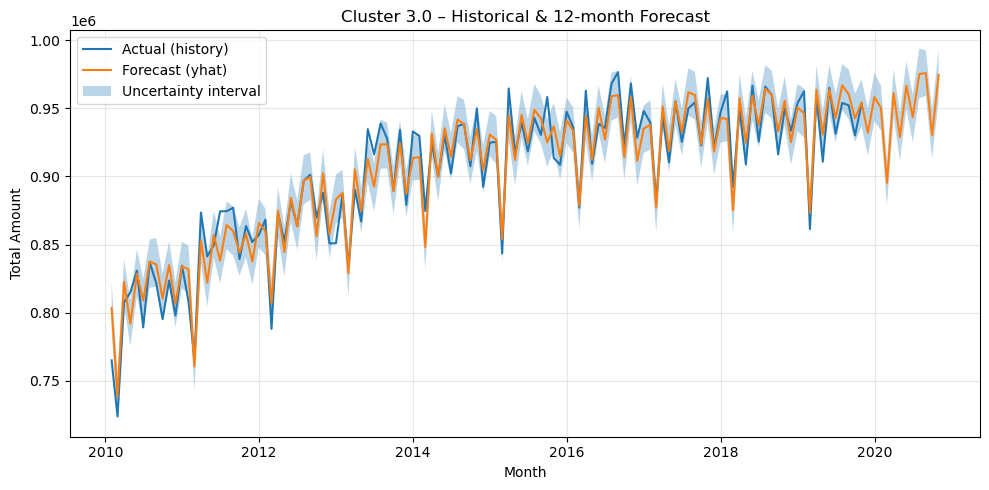

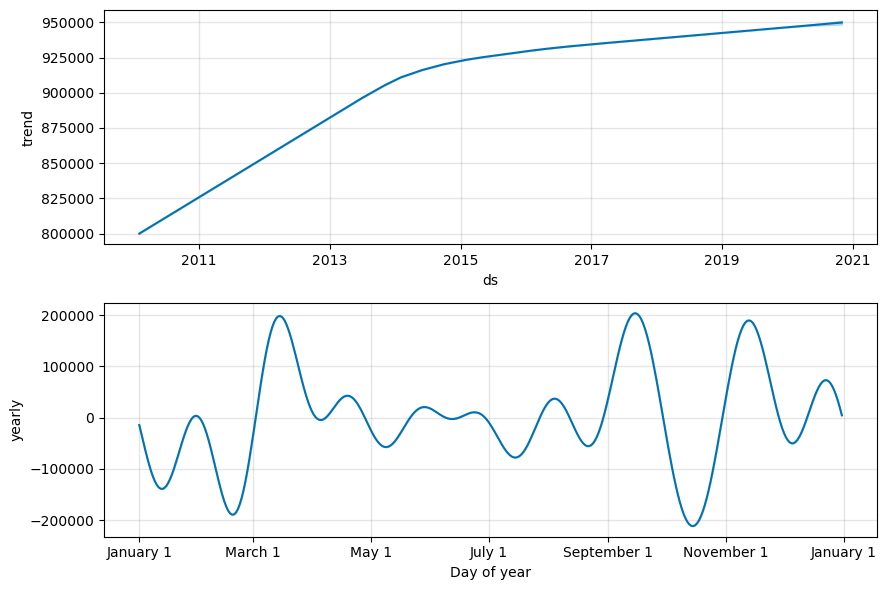

In [144]:
import matplotlib.pyplot as plt

def plot_cluster_final(c):
    ts_c = (
        cluster_monthly[cluster_monthly['Cluster'] == c]
        .sort_values('date')
        .set_index('date')['total_amount']
    )
    fc_c = final_forecasts[c]
    
    plt.figure(figsize=(10,5))
    plt.plot(ts_c.index, ts_c.values, label='Actual (history)')
    plt.plot(fc_c['ds'], fc_c['yhat'], label='Forecast (yhat)')
    plt.fill_between(fc_c['ds'], fc_c['yhat_lower'], fc_c['yhat_upper'],
                     alpha=0.3, label='Uncertainty interval')
    plt.title(f"Cluster {c} – Historical & 12-month Forecast")
    plt.xlabel("Month"); plt.ylabel("Total Amount")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

def plot_cluster_components(c):
    m_c = final_models[c]
    fc_c = final_forecasts[c]
    m_c.plot_components(fc_c);

# Run for all clusters:
for c in sorted(cluster_monthly['Cluster'].unique()):
    plot_cluster_final(c)
    plot_cluster_components(c)


# FINDINGS

In [146]:
cluster_names = {
    0.0: "Regular Spenders",
    1.0: "Conservative Budgeters",
    2.0: "Selective High-Value Purchasers",
    3.0: "Debt-Burdened Consistent Spenders"
}

summary_rows = []

for c in sorted(cluster_monthly['Cluster'].unique()):
    ts_c = (
        cluster_monthly[cluster_monthly['Cluster'] == c]
        .sort_values('date')
        .set_index('date')['total_amount']
    )
    
    # last 12 actual months
    hist_last_12 = ts_c.iloc[-12:]
    hist_mean = hist_last_12.mean()
    hist_total = hist_last_12.sum()
    
    # next 12 forecasted months
    fc_c = final_forecasts[c]
    last_hist_date = ts_c.index.max()
    fc_future = fc_c[fc_c['ds'] > last_hist_date].iloc[:12]
    fc_mean = fc_future['yhat'].mean()
    fc_total = fc_future['yhat'].sum()
    
    mean_growth_pct = (fc_mean - hist_mean) / hist_mean if hist_mean != 0 else 0
    total_growth_pct = (fc_total - hist_total) / hist_total if hist_total != 0 else 0
    
    summary_rows.append({
        'Cluster': c,
        'Cluster_Name': cluster_names[c],
        'hist_mean_last12': hist_mean,
        'fc_mean_next12': fc_mean,
        'mean_growth_pct': mean_growth_pct,
        'hist_total_last12': hist_total,
        'fc_total_next12': fc_total,
        'total_growth_pct': total_growth_pct
    })

summary_df = pd.DataFrame(summary_rows).sort_values('mean_growth_pct', ascending=False)
summary_df


,Cluster,Cluster_Name,hist_mean_last12,fc_mean_next12,mean_growth_pct,hist_total_last12,fc_total_next12,total_growth_pct
3,3.0000,Debt-Burdened Consistent Spenders,"939,014.5858","949,400.6056",0.0111,"11,268,175.0300","11,392,807.2668",0.0111
2,2.0000,Selective High-Value Purchasers,"1,390,870.9042","1,396,444.9806",0.0040,"16,690,450.8500","16,757,339.7669",0.0040
1,1.0000,Conservative Budgeters,"1,410,868.5992","1,413,560.8098",0.0019,"16,930,423.1900","16,962,729.7180",0.0019
0,0.0000,Regular Spenders,"1,209,976.8842","1,212,172.9382",0.0018,"14,519,722.6100","14,546,075.2585",0.0018


In [148]:
def label_growth(pct):
    if pct > 0.10:
        return "strong growth"
    elif pct > 0.03:
        return "moderate growth"
    elif pct > -0.03:
        return "flat / stable"
    else:
        return "decline"

summary_df['trend_label'] = summary_df['mean_growth_pct'].apply(label_growth)
summary_df


,Cluster,Cluster_Name,hist_mean_last12,fc_mean_next12,mean_growth_pct,hist_total_last12,fc_total_next12,total_growth_pct,trend_label
3,3.0000,Debt-Burdened Consistent Spenders,"939,014.5858","949,400.6056",0.0111,"11,268,175.0300","11,392,807.2668",0.0111,flat / stable
2,2.0000,Selective High-Value Purchasers,"1,390,870.9042","1,396,444.9806",0.0040,"16,690,450.8500","16,757,339.7669",0.0040,flat / stable
1,1.0000,Conservative Budgeters,"1,410,868.5992","1,413,560.8098",0.0019,"16,930,423.1900","16,962,729.7180",0.0019,flat / stable
0,0.0000,Regular Spenders,"1,209,976.8842","1,212,172.9382",0.0018,"14,519,722.6100","14,546,075.2585",0.0018,flat / stable


In [150]:
for _, row in summary_df.iterrows():
    c = int(row['Cluster'])
    name = row['Cluster_Name']
    growth = row['mean_growth_pct'] * 100
    trend = row['trend_label']
    
    print(
        f"Cluster {c} – {name}: "
        f"Prophet forecasts a {growth:.1f}% change in average monthly spending "
        f"over the next 12 months relative to the last 12 months, indicating {trend}."
    )


Cluster 3 – Debt-Burdened Consistent Spenders: Prophet forecasts a 1.1% change in average monthly spending over the next 12 months relative to the last 12 months, indicating flat / stable.
Cluster 2 – Selective High-Value Purchasers: Prophet forecasts a 0.4% change in average monthly spending over the next 12 months relative to the last 12 months, indicating flat / stable.
Cluster 1 – Conservative Budgeters: Prophet forecasts a 0.2% change in average monthly spending over the next 12 months relative to the last 12 months, indicating flat / stable.
Cluster 0 – Regular Spenders: Prophet forecasts a 0.2% change in average monthly spending over the next 12 months relative to the last 12 months, indicating flat / stable.
